In [1]:
# Retina mode
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import os
import subprocess

import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn.functional as F
import time

In [3]:
def load_example(df_row):
    image = torchvision.io.read_image(df_row['image_path'])
    
    result = {
        'image': image,
        'class': df_row['Class'] - 1
    }
    return result

In [4]:
class HiddenDataset(Dataset):
    def __init__(self, split='train'):
        super().__init__()
        self.examples = []
        df = pd.read_csv(f'100Objects/100objects_{split}.csv')
        df['image_path'] = df['Image_File'].apply(
            lambda x: os.path.join('100Objects/coil-100/', x))
        df = df.sort_values(by='image_path')
        df.apply(lambda row: self.examples.append(load_example(row)), axis=1)
        if len(self.examples) == 0:
            raise ValueError('No examples.')

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        example = self.examples[idx]
        image = example['image']
        image = image.to(torch.float32)
        example['image'] = image
        return example

In [5]:
def get_dataset(batch_size):
    train_ds = HiddenDataset(split='train')
    retain_ds = HiddenDataset(split='retain')
    forget_ds = HiddenDataset(split='forget')

    retain_loader = DataLoader(retain_ds, batch_size=batch_size, shuffle=True)
    forget_loader = DataLoader(forget_ds, batch_size=batch_size, shuffle=True)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    return retain_loader, forget_loader, train_loader

In [6]:
retain_loader, forget_loader, train_loader = get_dataset(1)

In [7]:
def accuracy(net, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images = data['image']
            labels = data['class']
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return acc

In [8]:
# model = resnet18(pretrained=False, num_classes=100) 

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# num_epochs = 10

# for epoch in range(num_epochs):
#     model.train()
#     for i , sample in enumerate(train_loader):

#         inputs = sample["image"]
#         labels = sample["class"]
#         optimizer.zero_grad()

#         # Make 3 channels for RGB
#         # inputs = torch.cat((inputs, inputs, inputs), 1)

#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#     print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# checkpoint_path = 'learned_reset_xc.pth'
# torch.save(model.state_dict(), checkpoint_path)

## Unlearning

In [9]:
def kl_loss(model_logits, teacher_logits, temperature=1.):
    teacher_output_softmax = F.softmax(teacher_logits / temperature, dim=1) 
    output_log_softmax = F.log_softmax(model_logits / temperature, dim=1)
    
    kl_div = F.kl_div(output_log_softmax, teacher_output_softmax, reduction='batchmean')
    return kl_div

In [10]:
def soft_cross_entropy(preds, soft_targets):
    loss = torch.sum(-soft_targets * torch.log_softmax(preds, dim=1), dim=1)
    return torch.mean(loss)

In [11]:
acc_retain_unlearned = []
acc_forget_unlearned = []

In [12]:
def unlearning(model, teacher_model, retain_loader, forget_loader, temperature=1.,
               weight=None):

    model.conv1.reset_parameters()
    model.fc.reset_parameters()
    
    teacher_model.eval()
    
    retain_epochs = 6
    
    acc_retain_unlearned.append(accuracy(model, retain_loader))
    acc_forget_unlearned.append(accuracy(model, forget_loader))

    criterion = nn.CrossEntropyLoss(weight=weight)

    optimizer = torch.optim.SGD(model.parameters(),
                                lr=1e-3, weight_decay=5e-4, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=retain_epochs
    )
    for epoch in range(retain_epochs):
        print(f'Retain epoch {epoch+1}/{retain_epochs}')
        model.train()
        for sample in retain_loader:
            x = sample["image"]
            y = sample["class"]
            optimizer.zero_grad()
            out = model(x)
            with torch.no_grad():
                teacher_out = teacher_model(x)
            soft_labels = torch.softmax(teacher_out / temperature, dim=1)
            soft_predictions = torch.log_softmax(out / temperature, dim=1)
            loss = soft_cross_entropy(soft_predictions, soft_labels)
            loss += criterion(out, y)
            loss += kl_loss(model_logits=out, 
                           teacher_logits=teacher_out, 
                           temperature=temperature)
            loss.backward()
            optimizer.step()
        scheduler.step()

        acc_retain_unlearned.append(accuracy(model, retain_loader))
        acc_forget_unlearned.append(accuracy(model, forget_loader))

    model.eval()

In [13]:
original_net = resnet18(weights=None, num_classes=100)
original_net.load_state_dict(torch.load('learned_reset_xc.pth'))

acc_original_retain = accuracy(original_net, retain_loader)
acc_original_forget = accuracy(original_net, forget_loader)

unleaned_net = resnet18(weights=None, num_classes=100)
unleaned_net.load_state_dict(torch.load('learned_reset_xc.pth'))

acc_retain_unlearned.append(accuracy(unleaned_net, retain_loader))
acc_forget_unlearned.append(accuracy(unleaned_net, forget_loader))
start = time.process_time()
unlearning(unleaned_net , original_net , retain_loader , forget_loader , 5 , None)
time_unlearned = (time.process_time() - start)

state = unleaned_net.state_dict()
torch.save(state, 'unlearned_resnet_resetting_layer_xc.pth')

Retain epoch 1/6
Retain epoch 2/6
Retain epoch 3/6
Retain epoch 4/6
Retain epoch 5/6
Retain epoch 6/6


In [14]:
print(f'Original model accuracy on retain: {acc_original_retain}')
print(f'Original model accuracy on forget: {acc_original_forget}')
print(f'Unlearned model accuracy on retain: {acc_retain_unlearned[-1]}')
print(f'Unlearned model accuracy on forget: {acc_forget_unlearned[-1]}')

Original model accuracy on retain: 90.81632653061224
Original model accuracy on forget: 100.0
Unlearned model accuracy on retain: 86.73469387755102
Unlearned model accuracy on forget: 0.0


In [15]:
print(f"Time taken for unlearning: {time_unlearned}")

Time taken for unlearning: 1210.9375


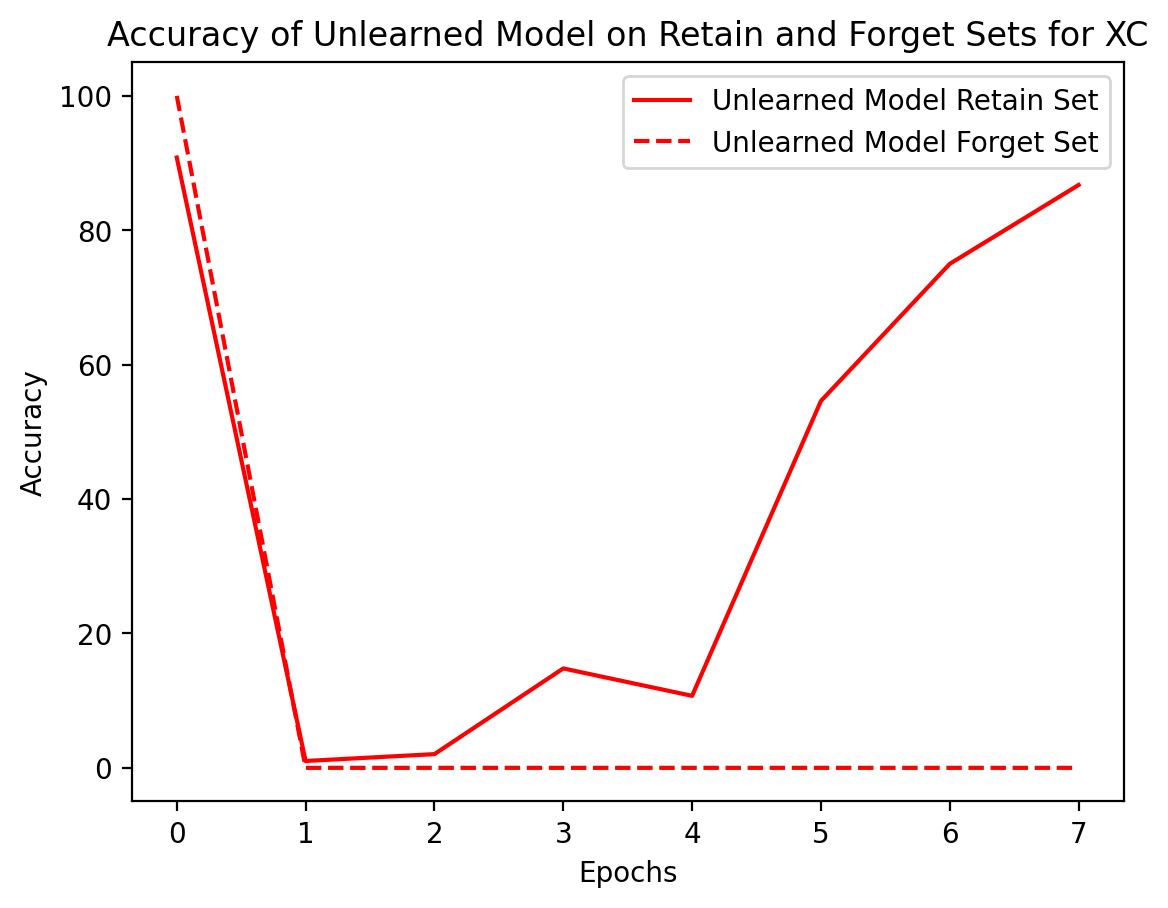

In [16]:
# Plot the accuracy of the models
import matplotlib.pyplot as plt

plt.plot(acc_retain_unlearned, label="Unlearned Model Retain Set" , color = 'red')
plt.plot(acc_forget_unlearned, label="Unlearned Model Forget Set" , color = 'red' , linestyle = 'dashed')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy of Unlearned Model on Retain and Forget Sets for XC")
plt.savefig("posterimgs/acc_xc.png")
plt.show()

In [17]:
original_net = resnet18(weights=None, num_classes=100)
original_net.load_state_dict(torch.load('learned_reset_xc.pth'))

unleaned_net = resnet18(weights=None, num_classes=100)
unleaned_net.load_state_dict(torch.load('unlearned_resnet_resetting_layer_xc.pth'))

<All keys matched successfully>

In [18]:
forget_logits_learned = []
forget_logits_unlearned = []
labels = []

for sample in forget_loader:
    x = sample["image"]
    y = sample["class"]
    out_learned = original_net(x)
    out_unlearned = unleaned_net(x)
    forget_logits_learned.append(out_learned)
    forget_logits_unlearned.append(out_unlearned)
    labels.append(y)

In [19]:
#Take sigmoid of the logits to get the probabilities
forget_probs_learned = torch.sigmoid(torch.cat(forget_logits_learned))
forget_probs_unlearned = torch.sigmoid(torch.cat(forget_logits_unlearned))

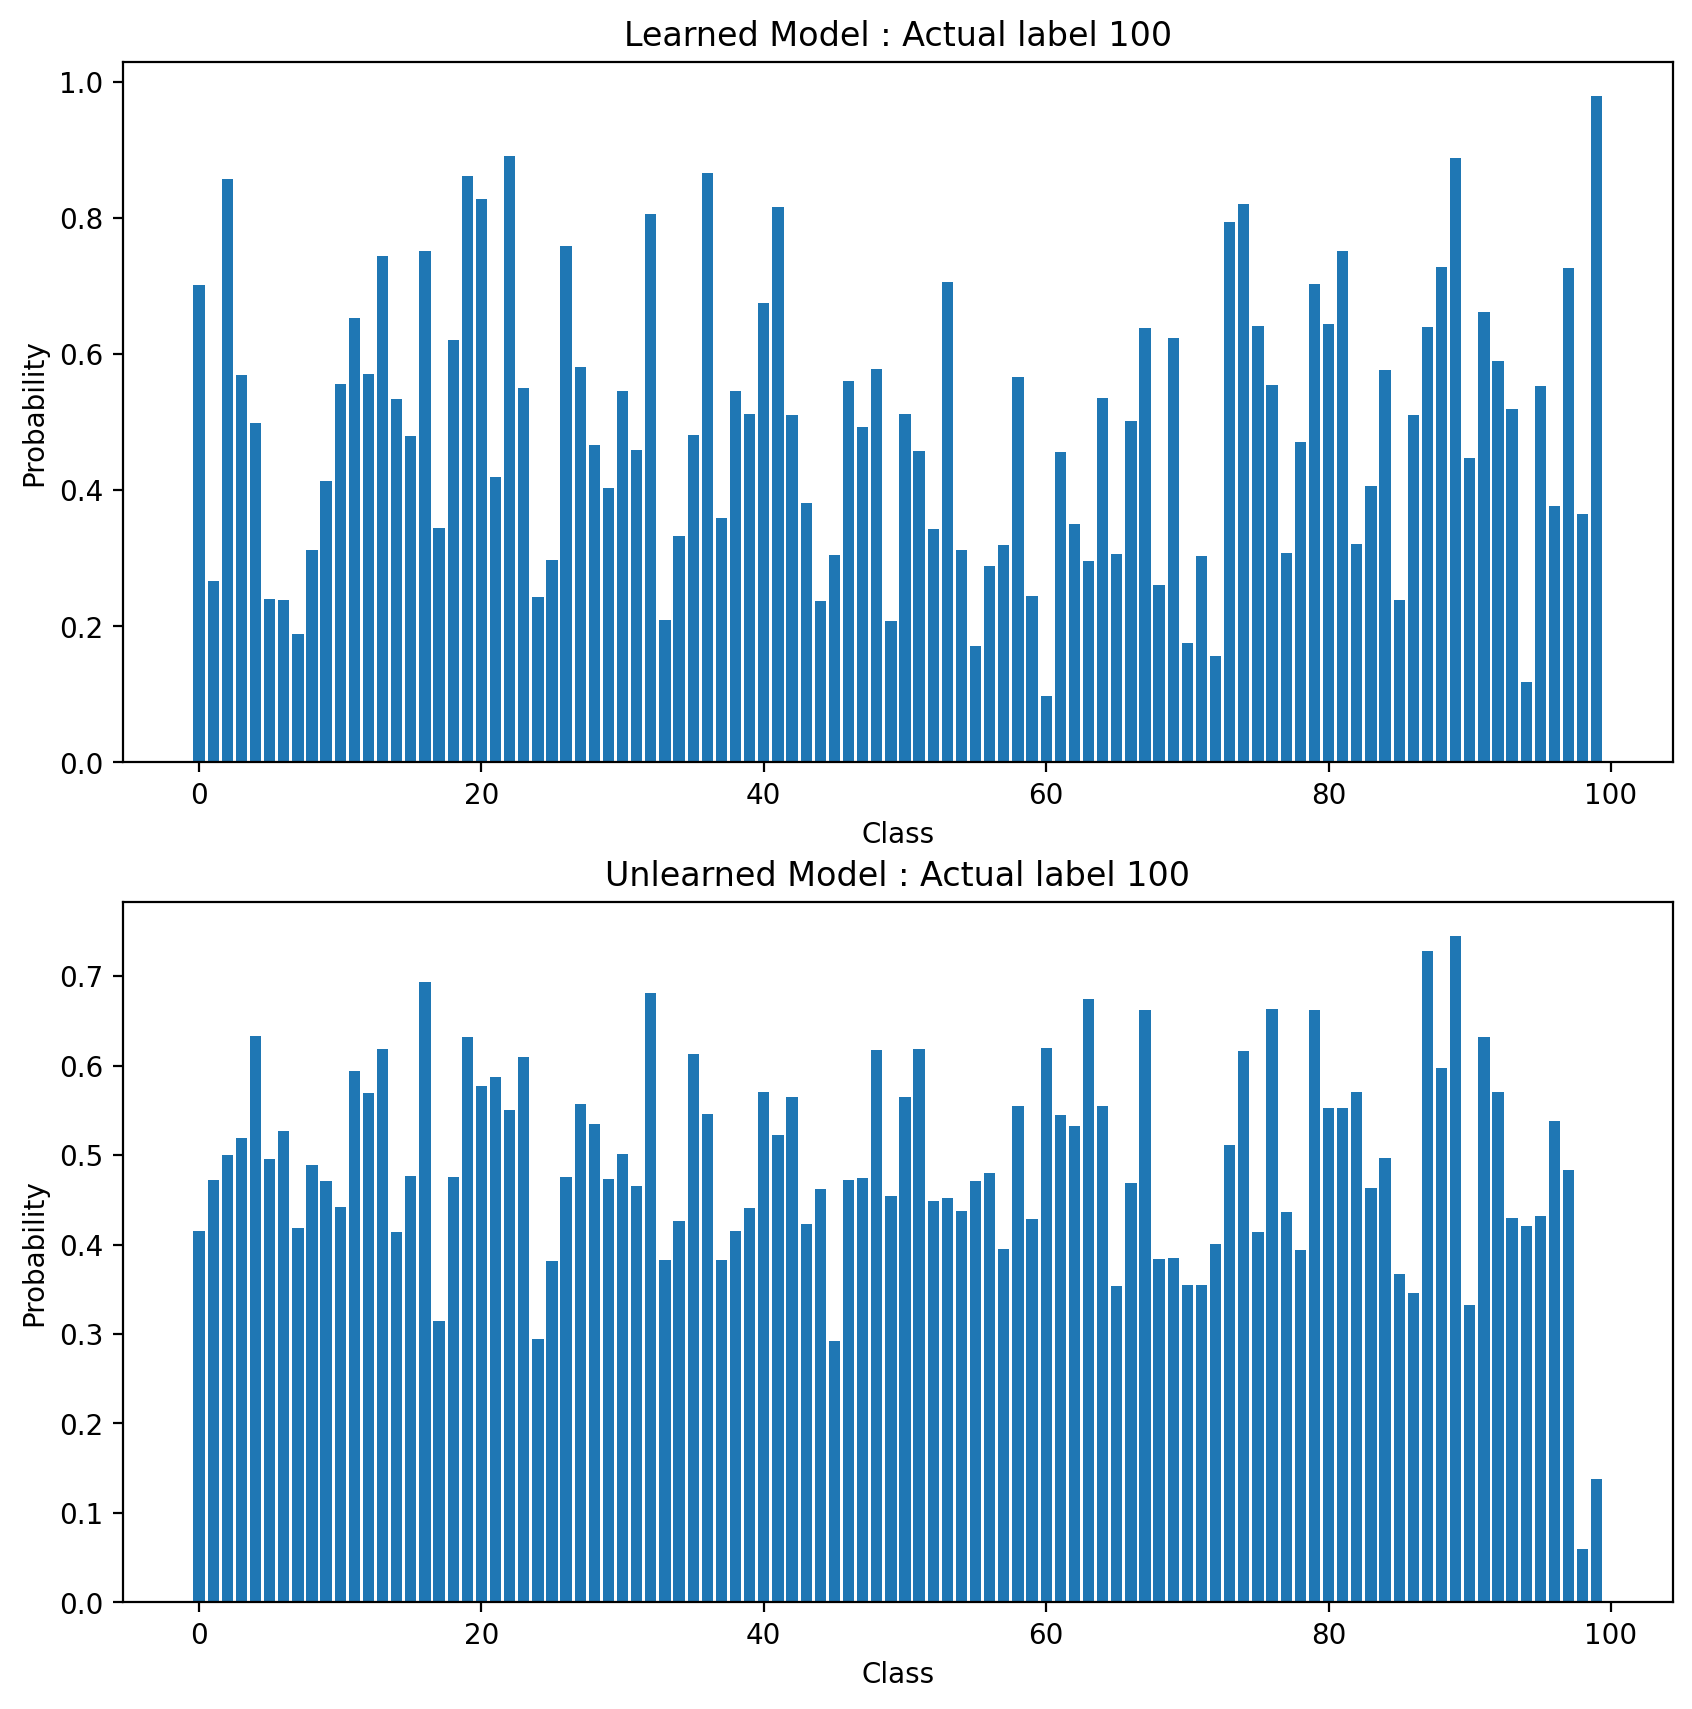

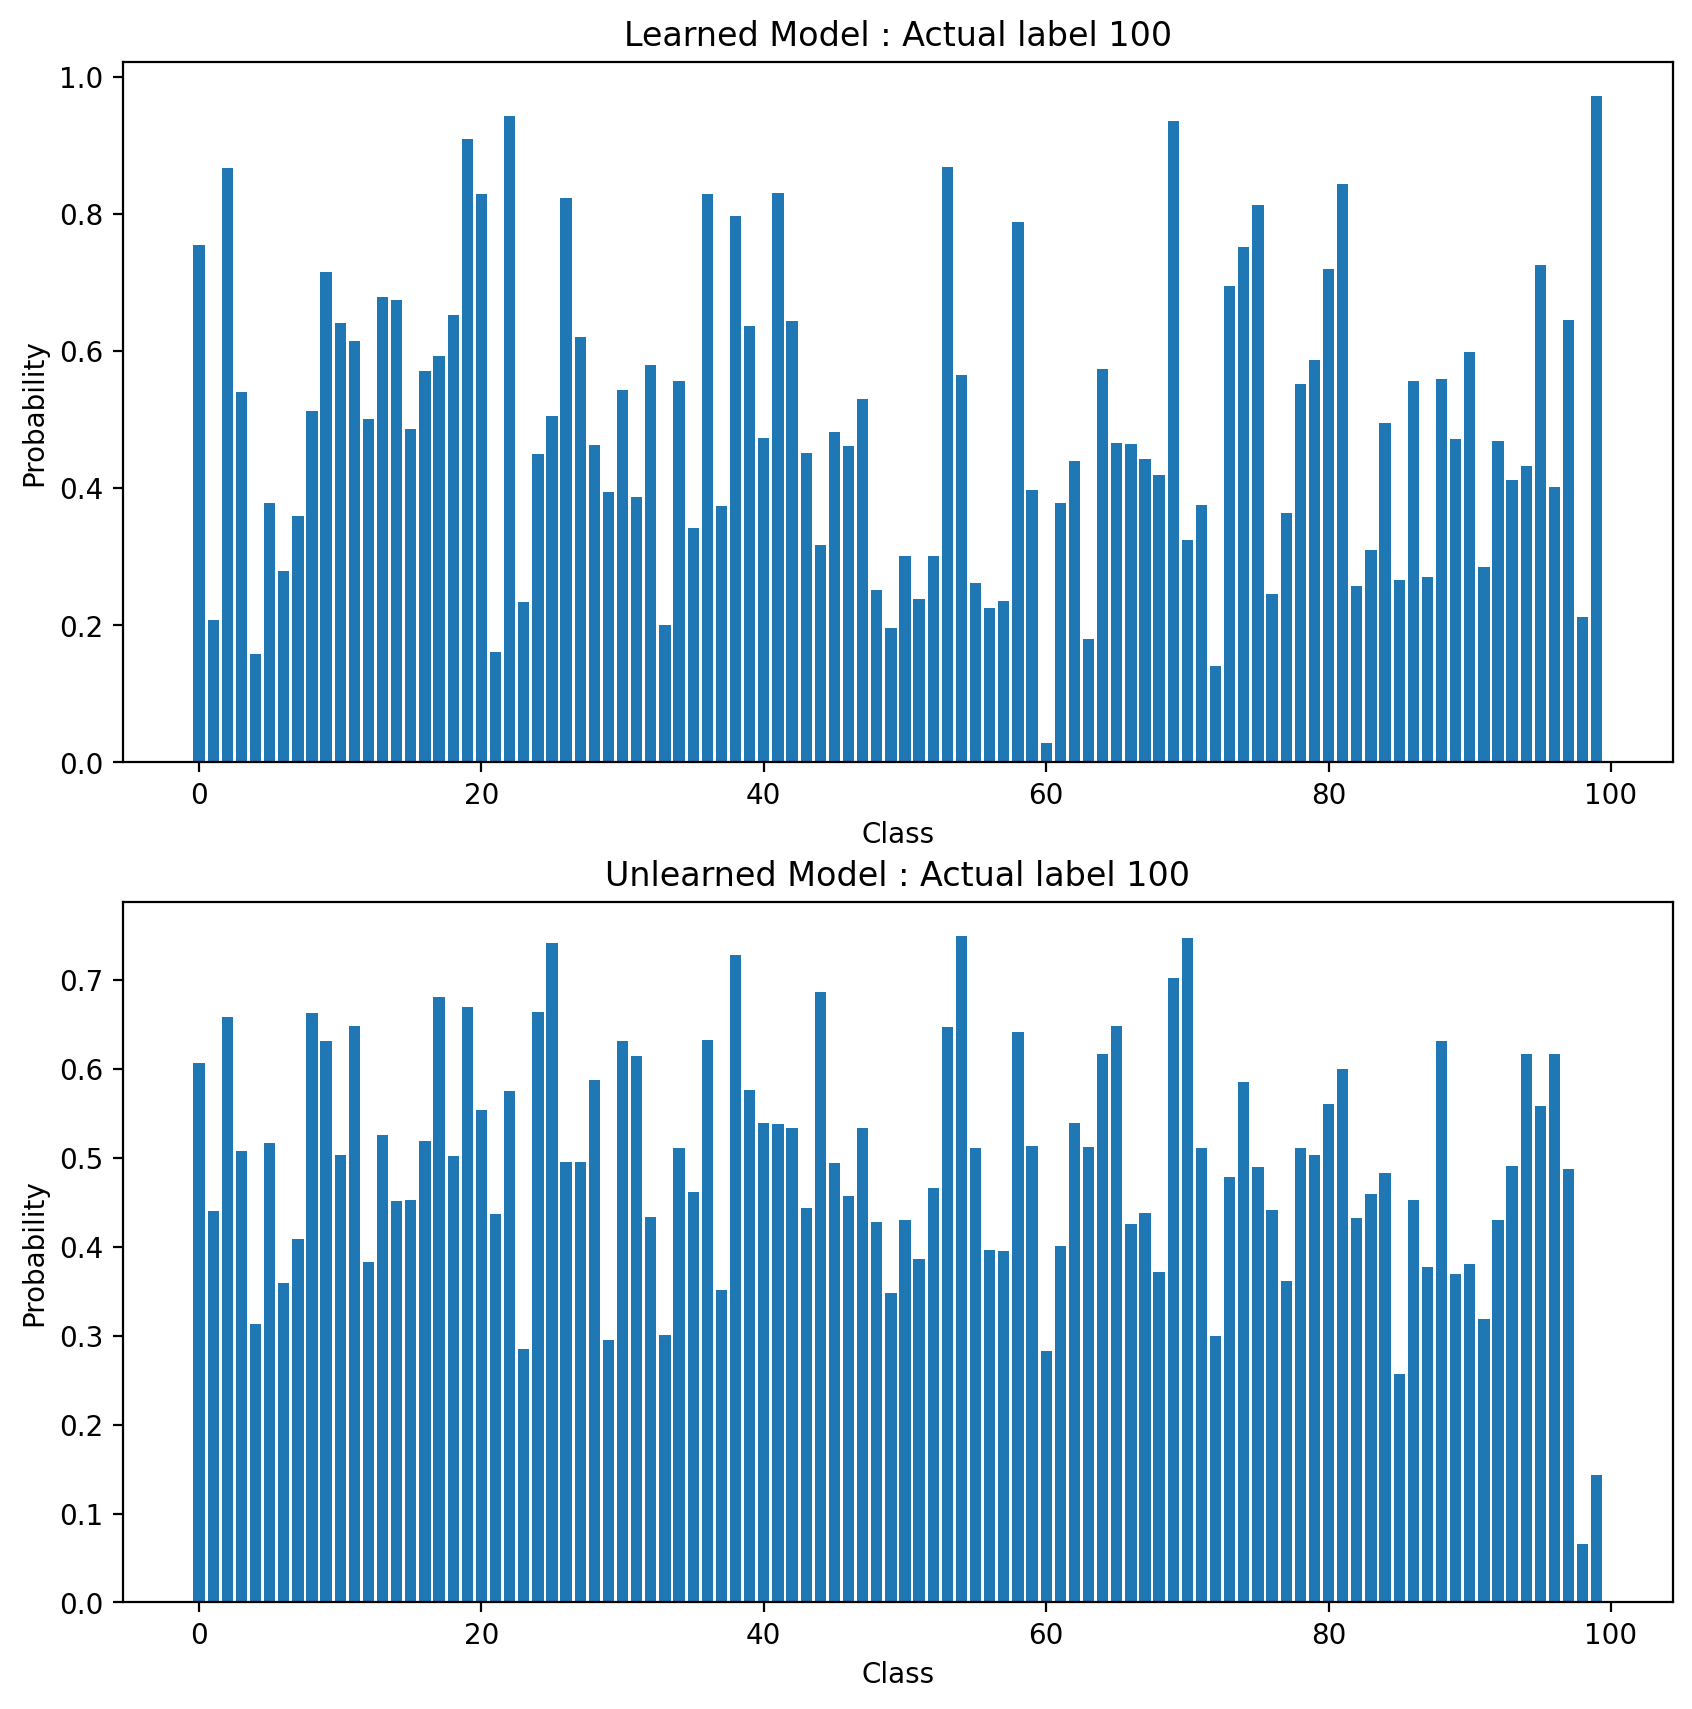

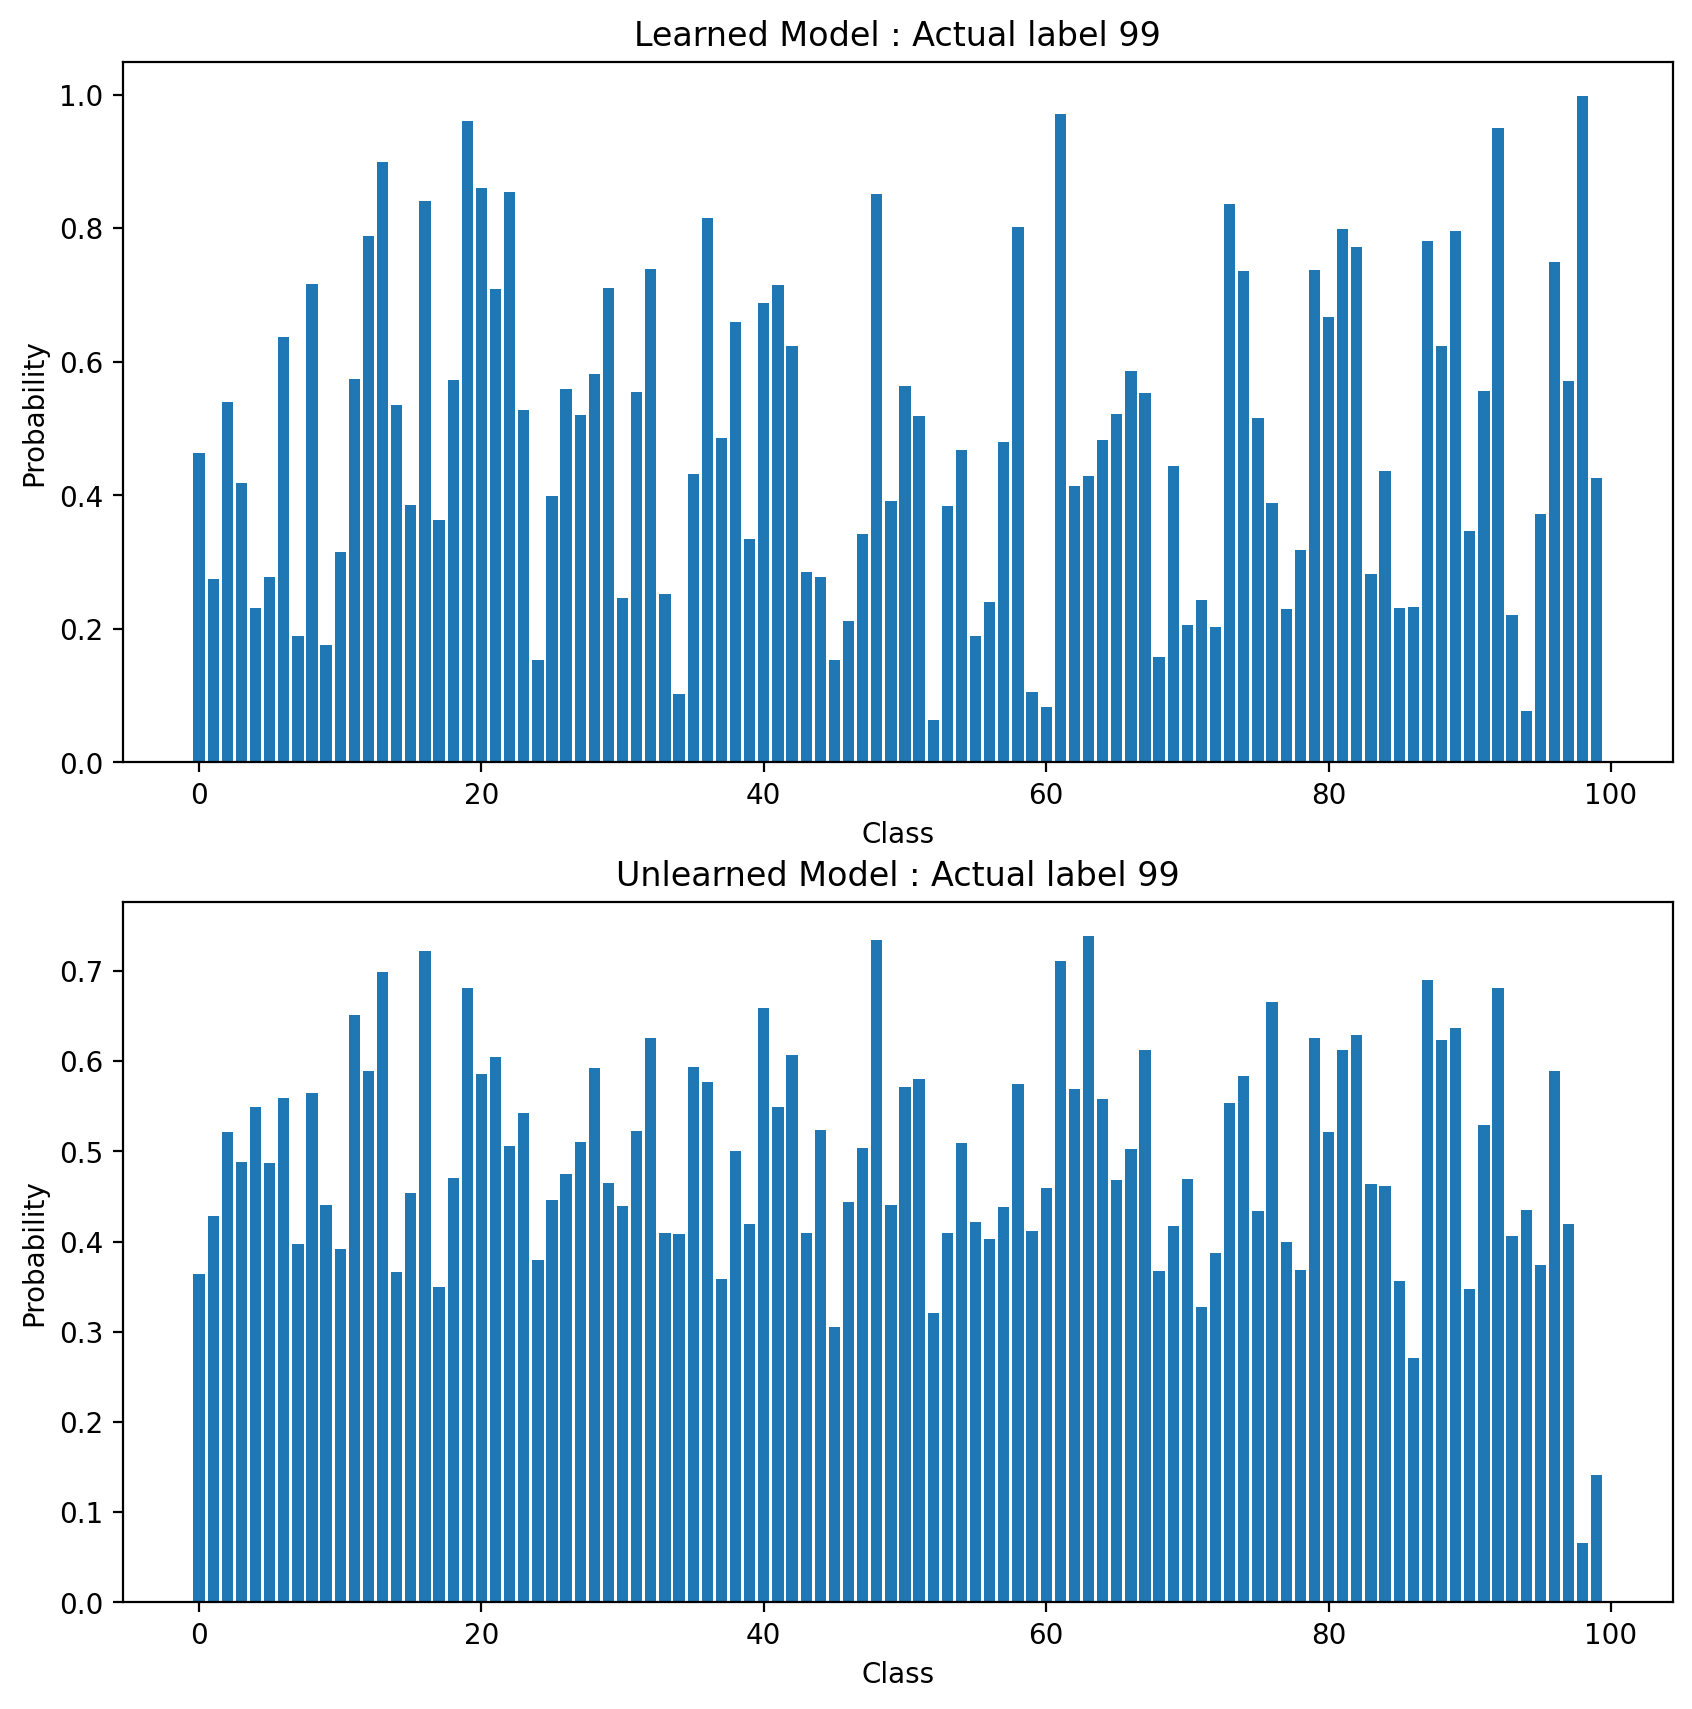

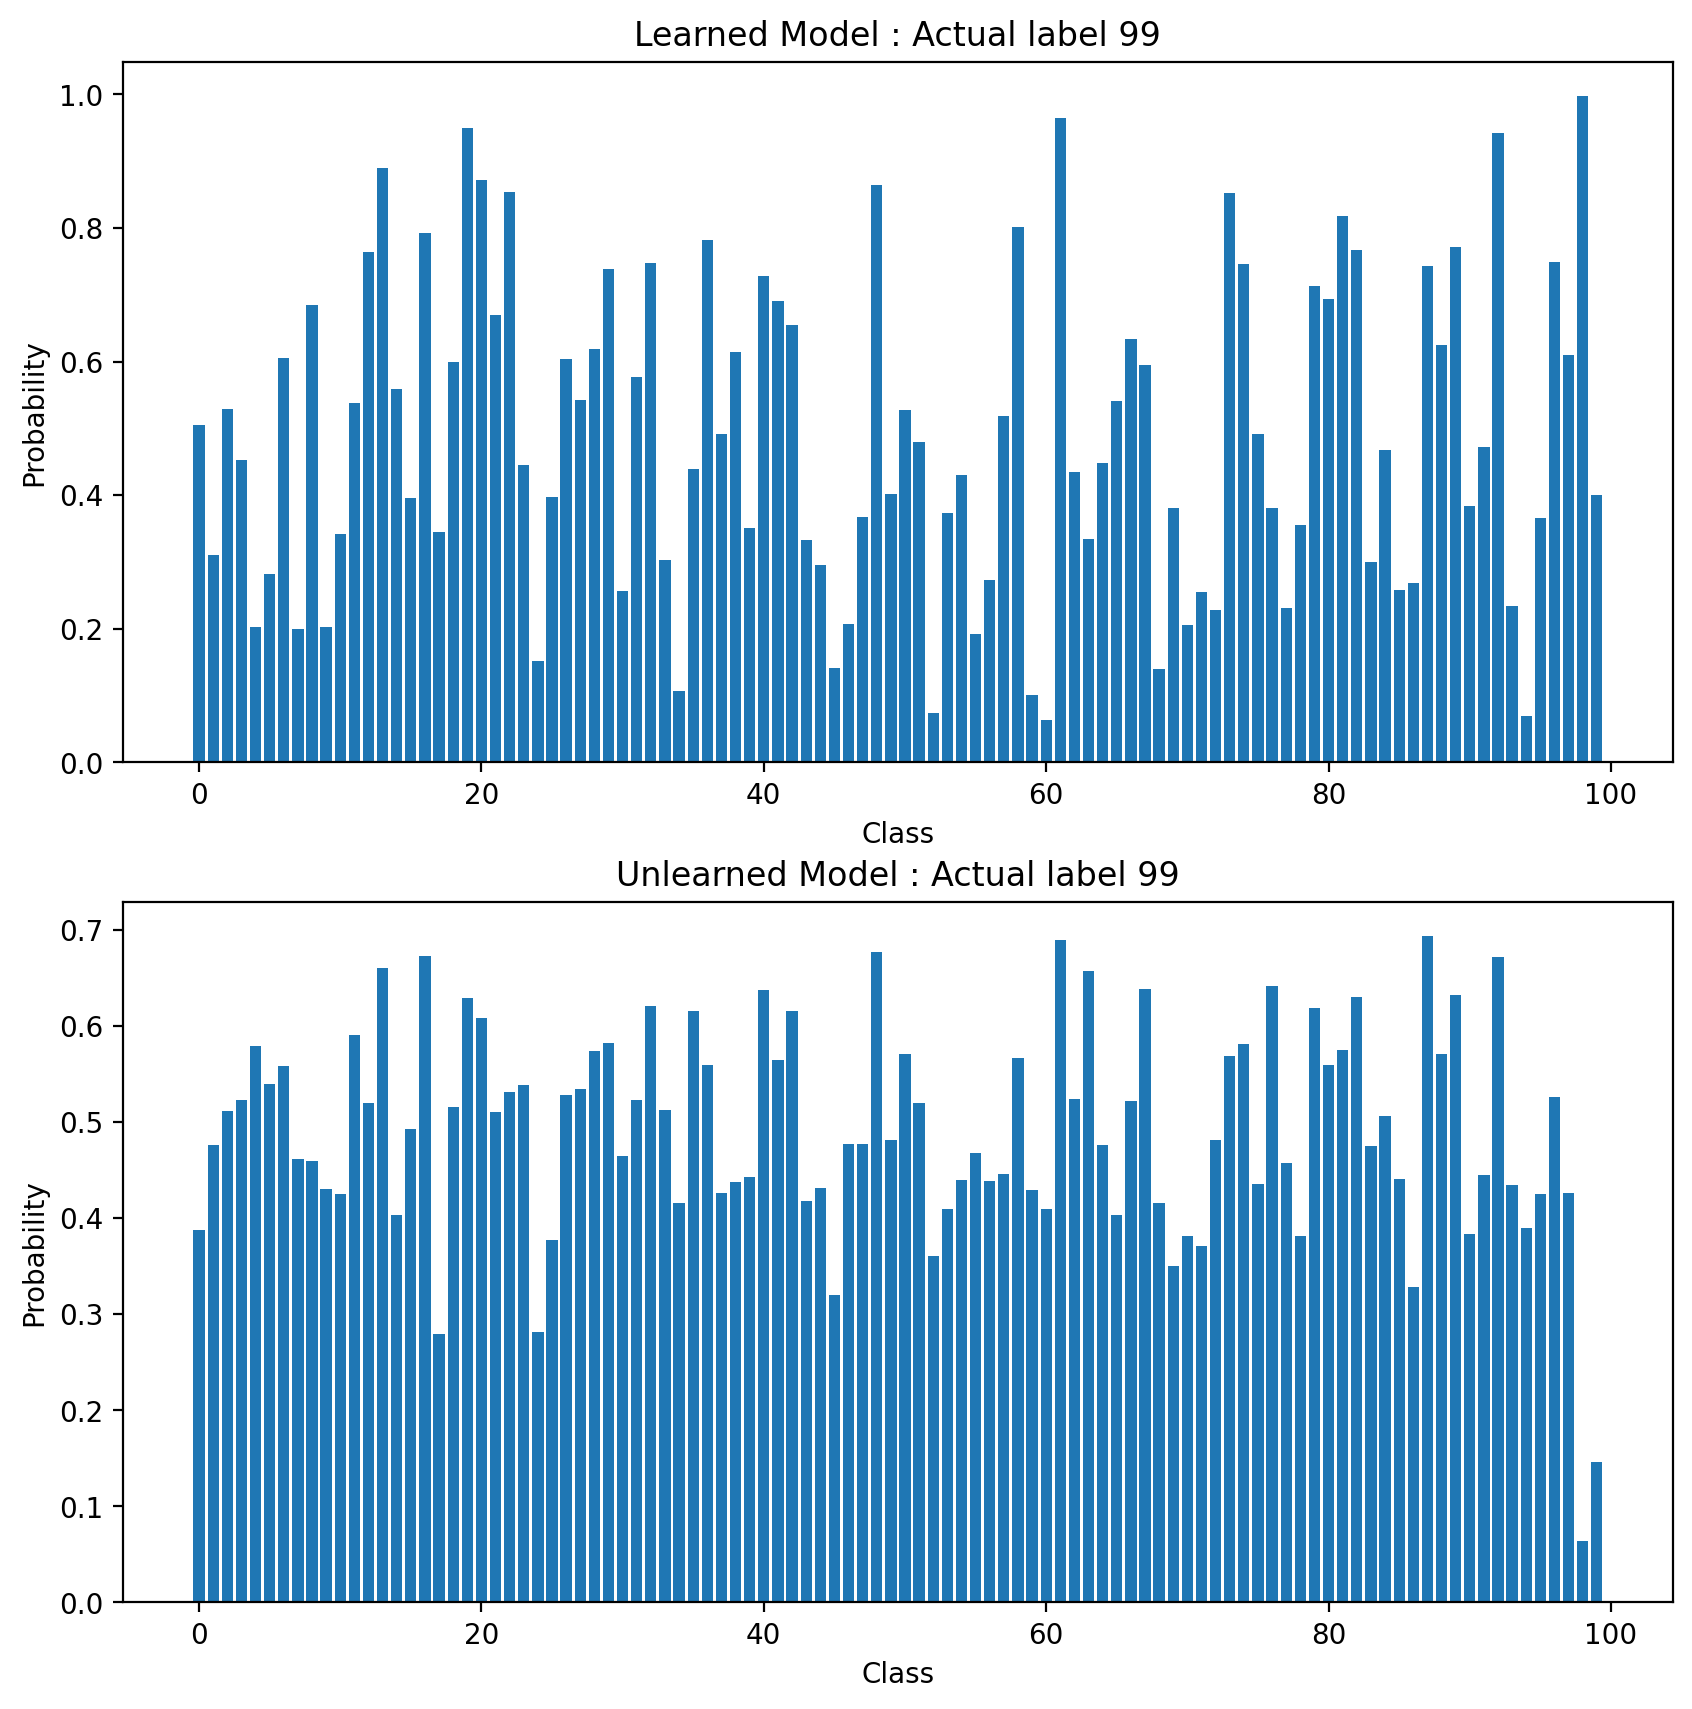

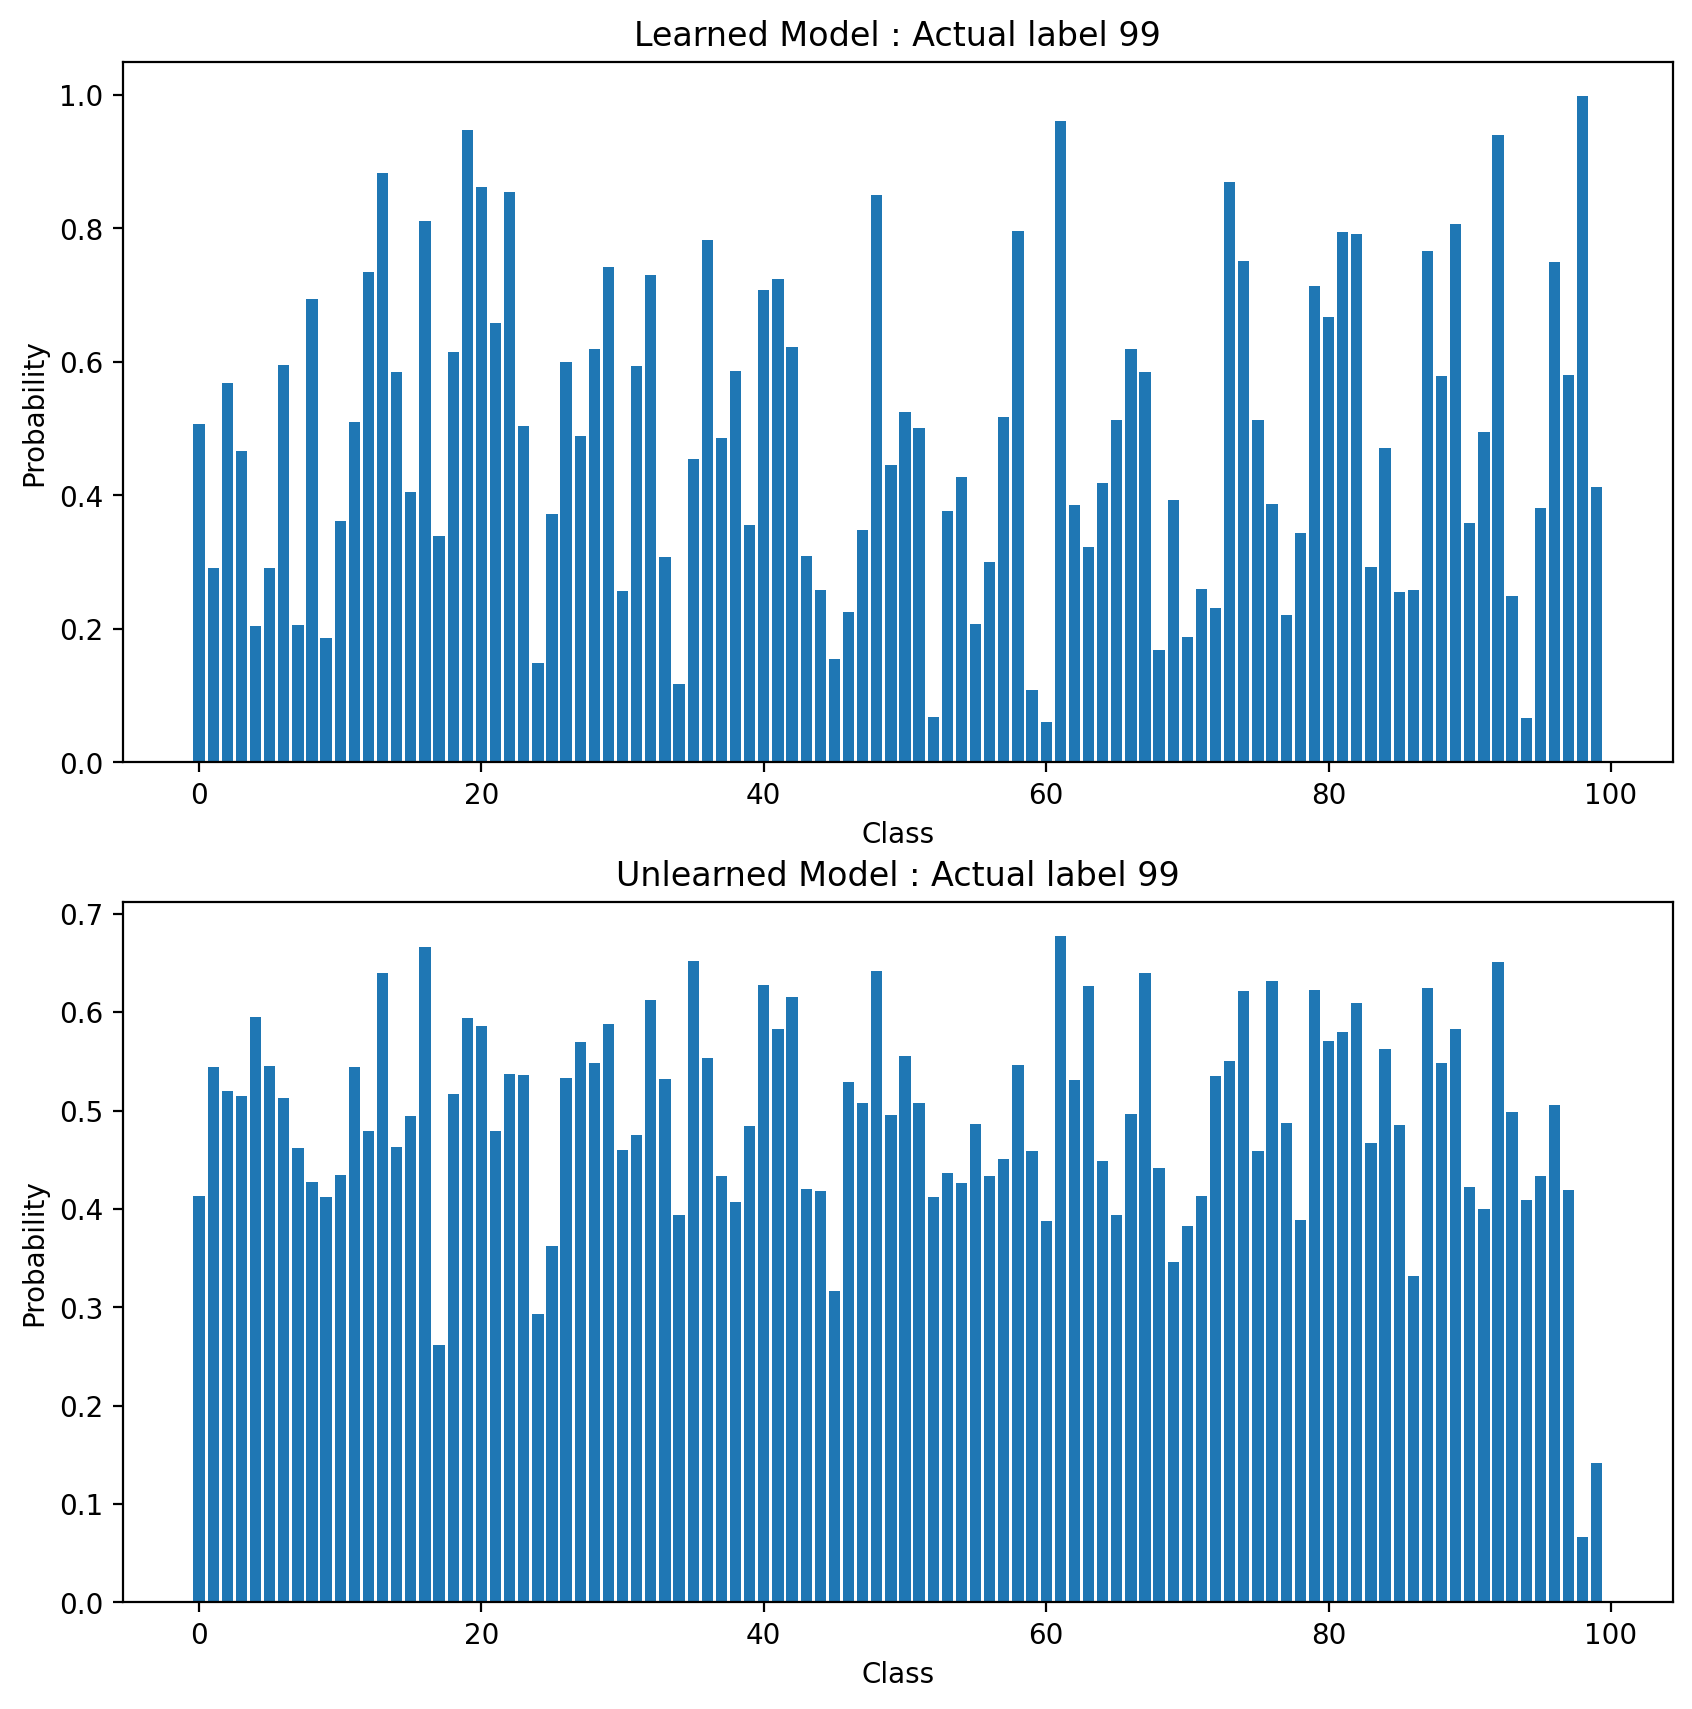

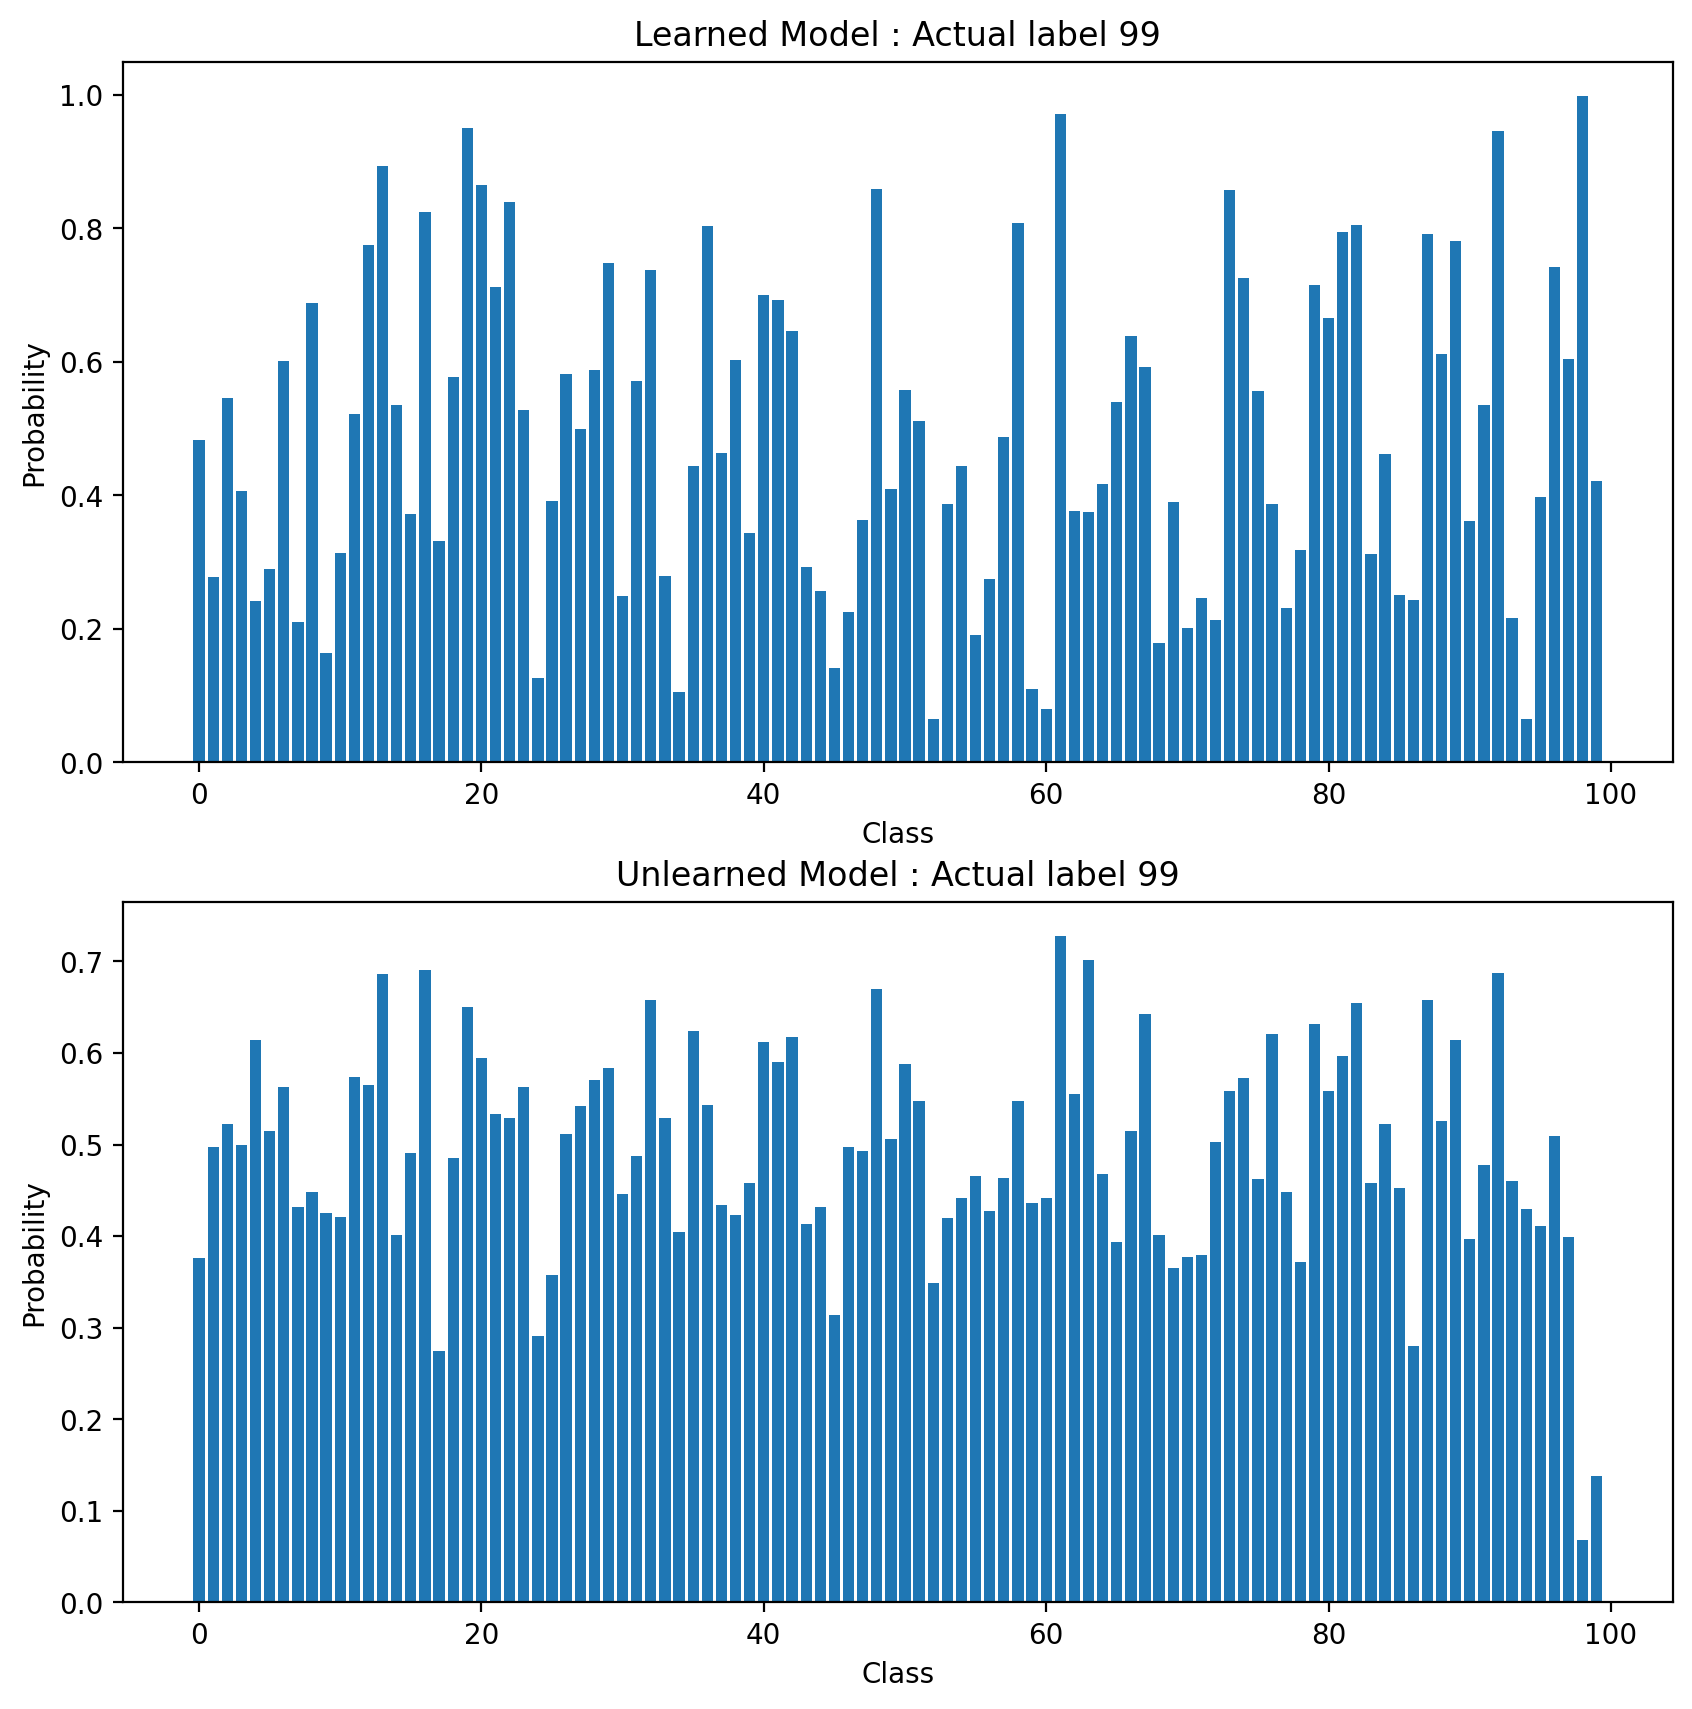

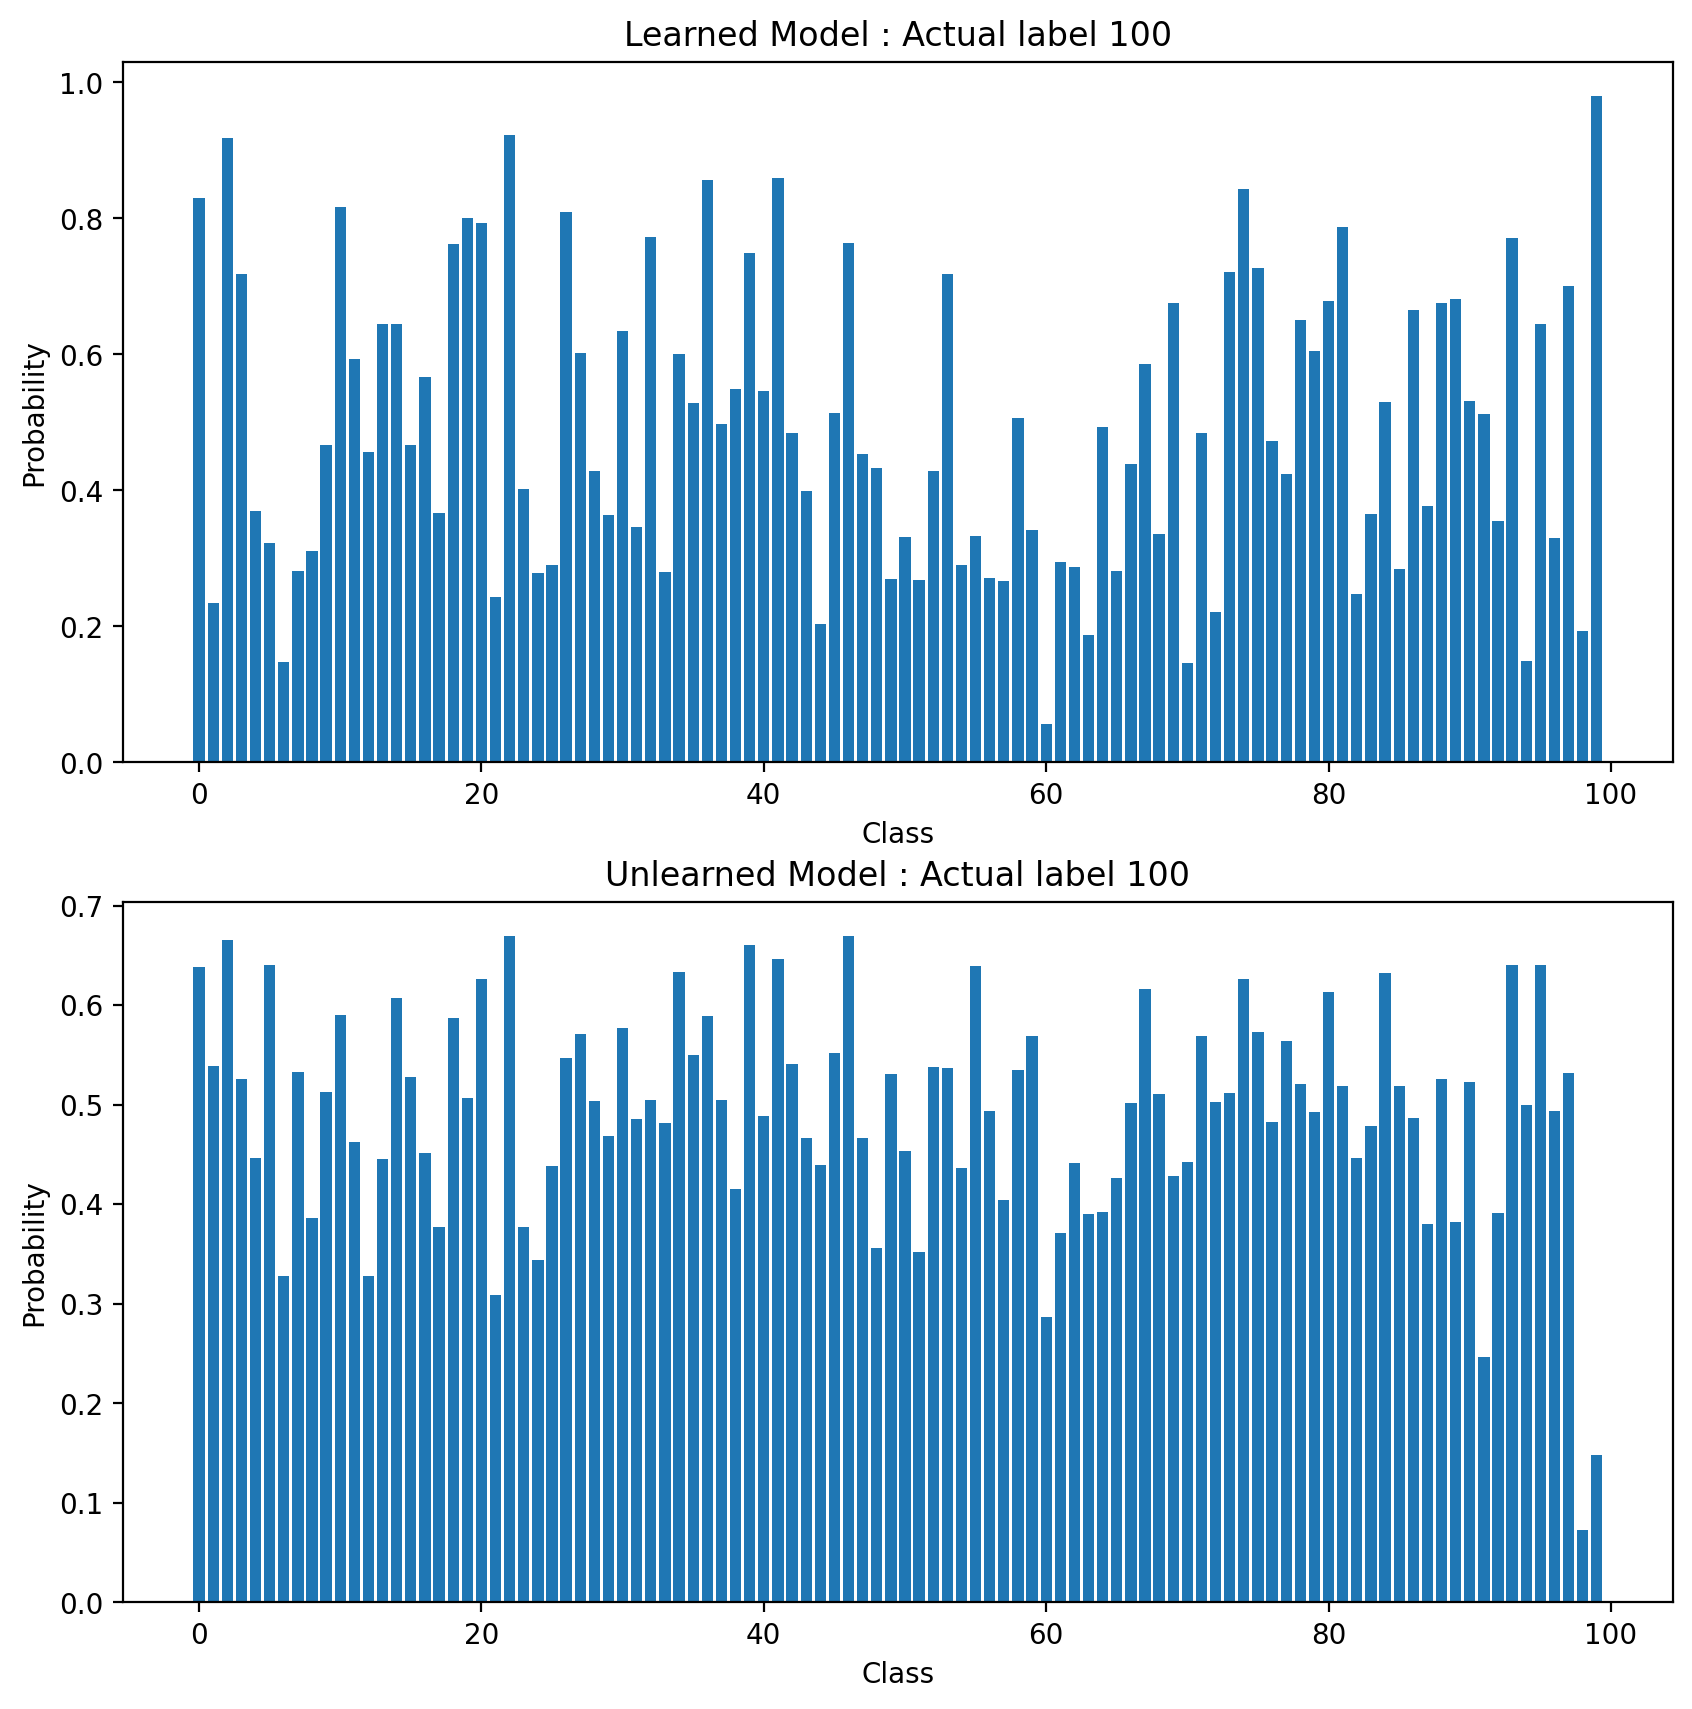

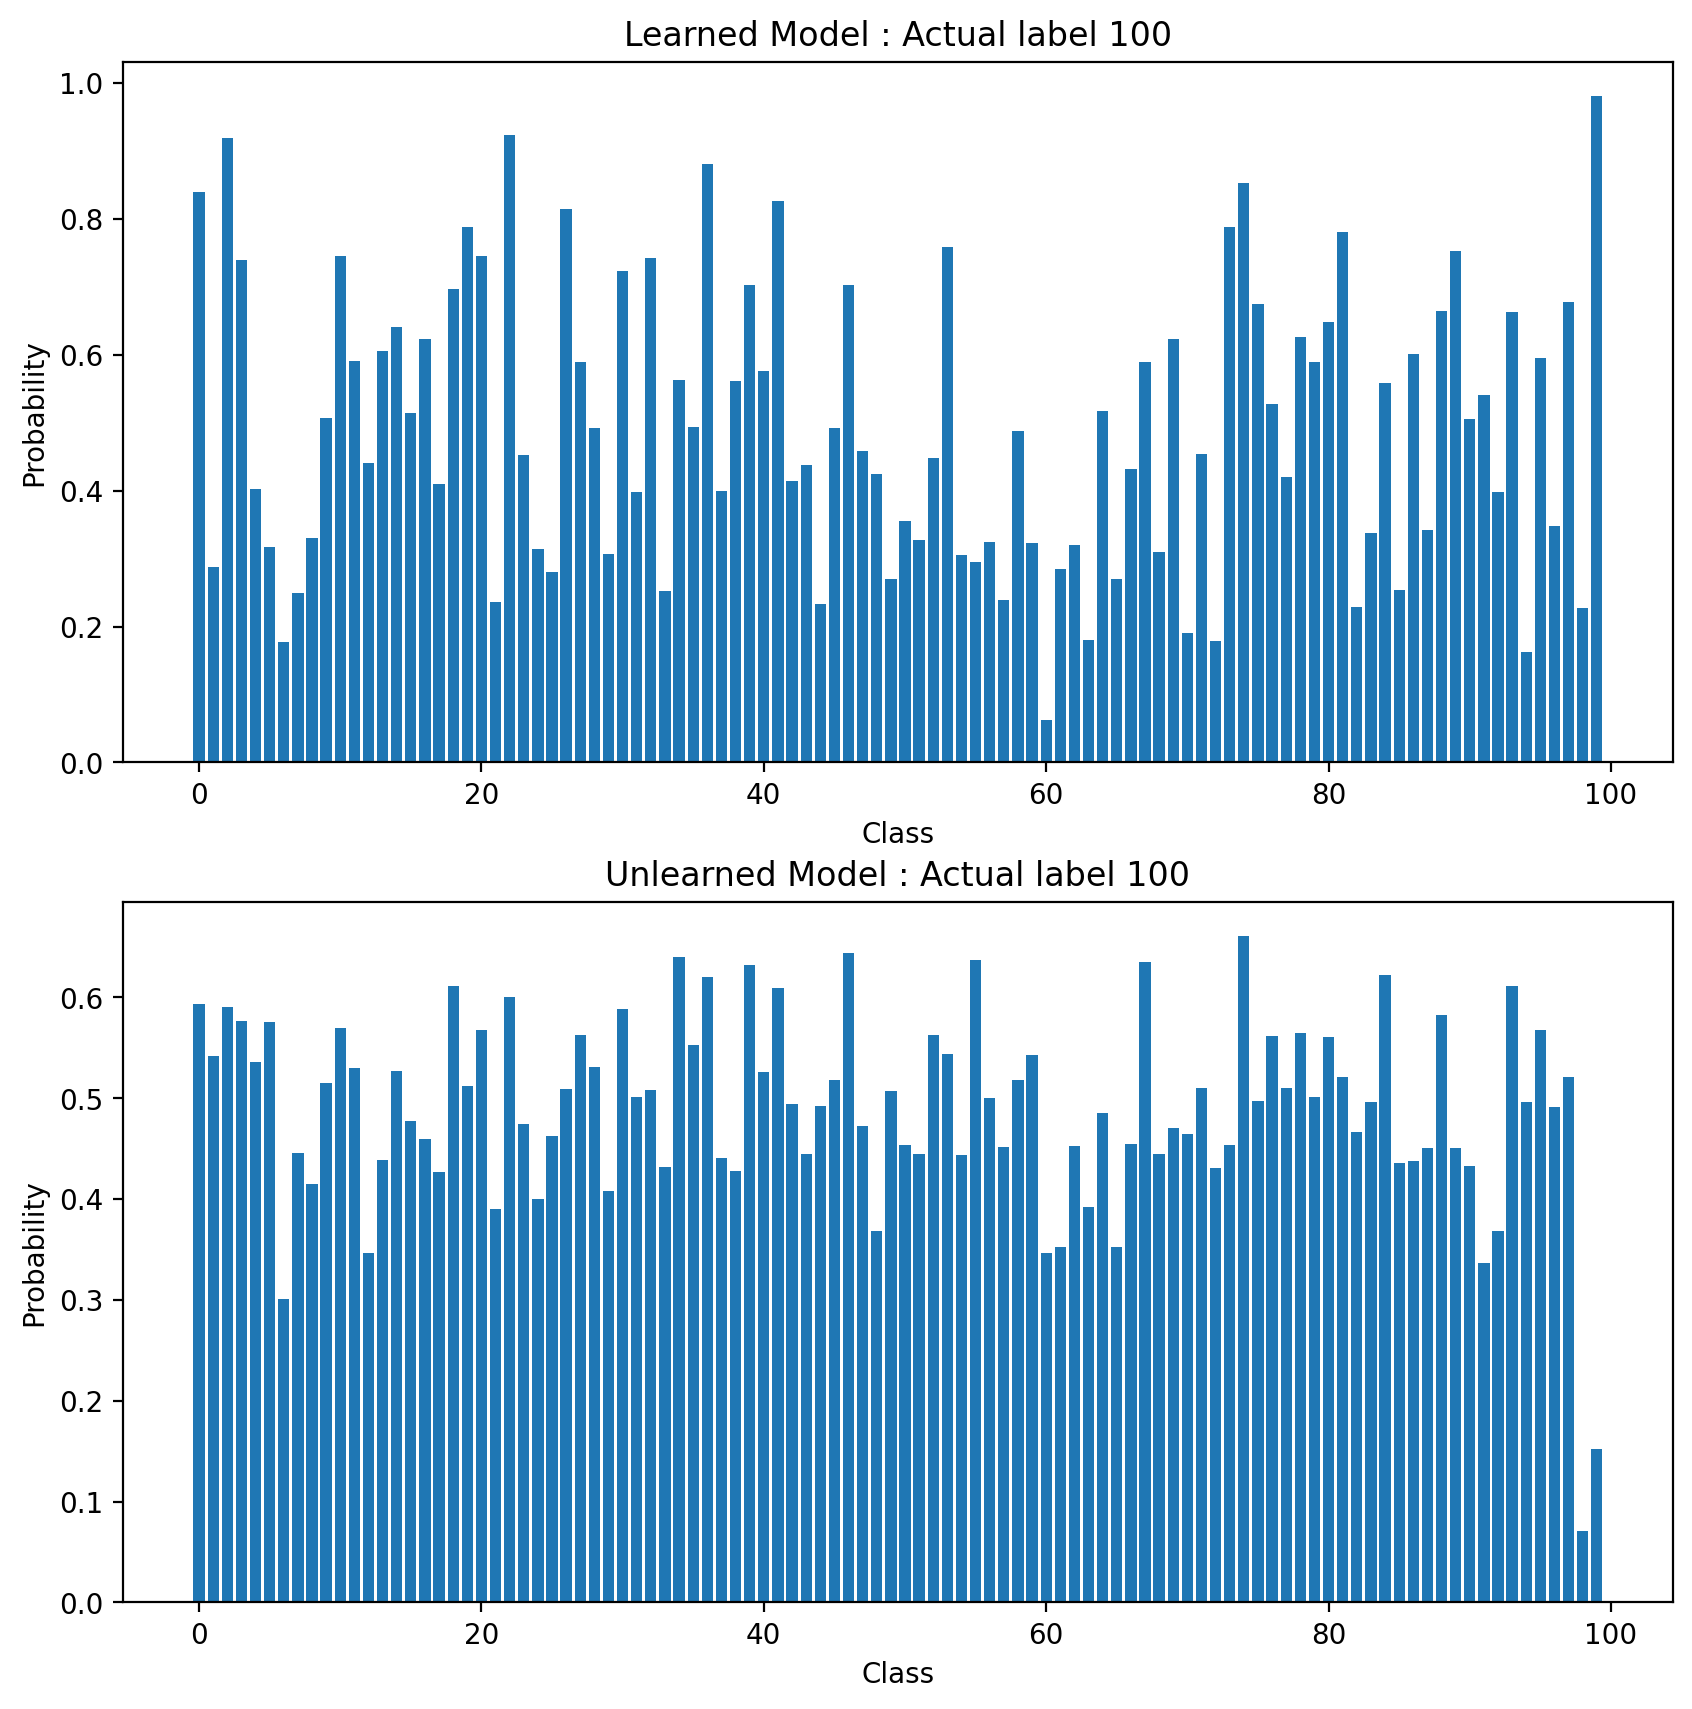

In [20]:
for i in range(forget_probs_learned.shape[0]):
    p1 = forget_probs_learned[i].detach().numpy()
    p2 = forget_probs_unlearned[i].detach().numpy()

    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    ax[0].bar(range(100), p1)
    ax[0].set_title('Learned Model : Actual label {}'.format(labels[i].item()+1))
    ax[0].set_xlabel('Class')
    ax[0].set_ylabel('Probability')

    ax[1].bar(range(100), p2)
    ax[1].set_title('Unlearned Model : Actual label {}'.format(labels[i].item()+1))
    ax[1].set_xlabel('Class')
    ax[1].set_ylabel('Probability')

    plt.show()